In [1]:
from fastText import load_model
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pylab
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

dtype = torch.FloatTensor

In [2]:
# Read data into string, split into words and finally separate into train and valid sets
valid_size = 1000

with open('text8') as file:
    data = file.read()
words = data.split()
valid_words = words[:valid_size]
train_words = words[valid_size:]
train_size = len(train_words)

print(valid_size, valid_words[:10])
print(train_size, train_words[:10])

1000 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
17004207 ['american', 'individualist', 'anarchism', 'benjamin', 'tucker', 'in', 'one', 'eight', 'two', 'five']


In [3]:
# Fasttext model containing word vectors of text8 data
ft_model = load_model('text8_ft.bin')
# Unkown token
words = ['UNK']
# Get all words from model
words.extend(ft_model.get_words())

In [46]:
# Size of vocabulary
vocab_size = len(words) 
# Number of dimensions of word vectors
num_dim = ft_model.get_dimension()

# Retrieve word vectors from model and store in numpy ndarray
embeddings = np.zeros((vocab_size, num_dim))
for i in range(vocab_size):
    vector = ft_model.get_word_vector(words[i])
    embeddings[i] = vector

print('Vocabulary size: %d' % vocab_size)
print('Dimensions of word_vectors: %d' % num_dim)

Vocabulary size: 71291
Dimensions of word_vectors: 300


In [28]:
# dictionary -> word : index
# reverse_dictionary -> index : word
dictionary = dict()
for word in words:
    dictionary[word] = len(dictionary)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [29]:
# TSNE and matplotlib to plot word embeddings in 2d space
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embeddings[1:num_points+1, :])

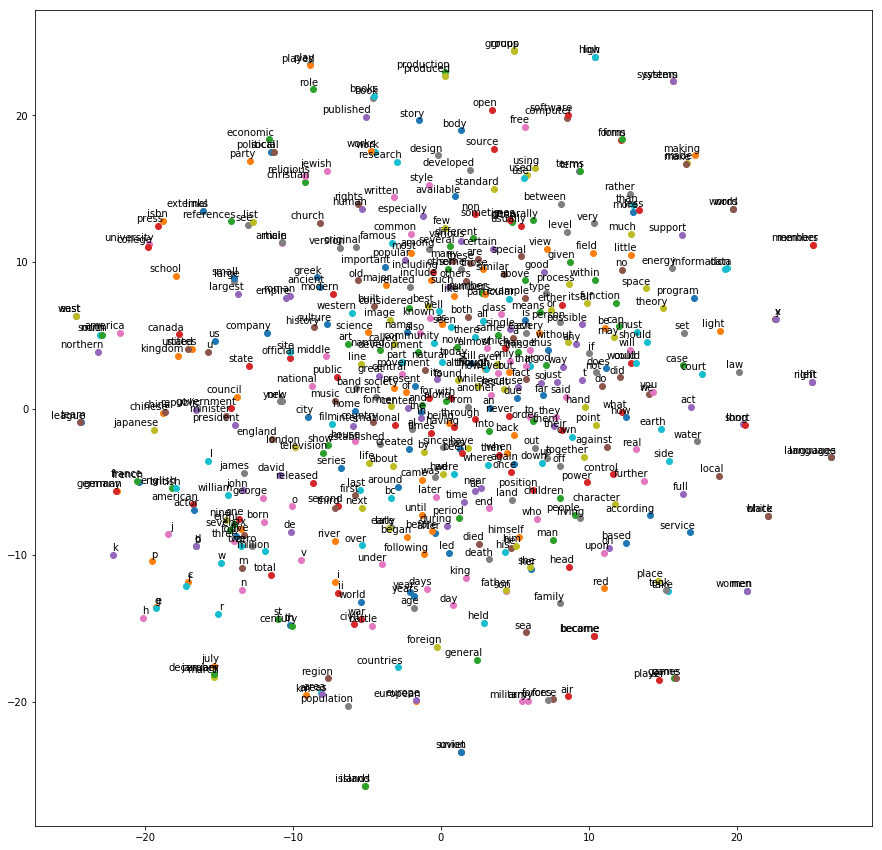

In [30]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

plot_words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, plot_words)

In [42]:
batch_size = 128
seq_len = 10

class BatchGenerator(object):
    
    def __init__(self, corpus, batch_size, seq_len):
        self._corpus = corpus
        self._corpus_size = len(corpus)
        self._batch_size = batch_size
        self._seq_len = seq_len
        segment = self._corpus_size // batch_size
        # cursor -> list of offsets separated by segment number of words
        self._cursor = [offset*segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()
        
    def _next_batch(self):
        # Each batch is a torch LongTensor containing word indices
        batch = torch.cuda.LongTensor(batch_size)  #batch = torch.LongTensor(batch_size)
        for b in range(self._batch_size):
            word = self._corpus[self._cursor[b]]
            if word not in dictionary:
                batch[b] = dictionary['UNK']
            else:
                batch[b] = dictionary[word]
            self._cursor[b] = (self._cursor[b] + 1) % self._corpus_size
        return batch
    
    def _next(self):
        batches = [self._last_batch]
        for step in range(self._seq_len):
            batch = self._next_batch()
            batches.append(batch)
        self._last_batch = batches[-1]
        return batches
    
train_batches = BatchGenerator(train_words, batch_size, seq_len)
valid_batches = BatchGenerator(valid_words, 1, 1)

Pytorch documentation of Embedding class

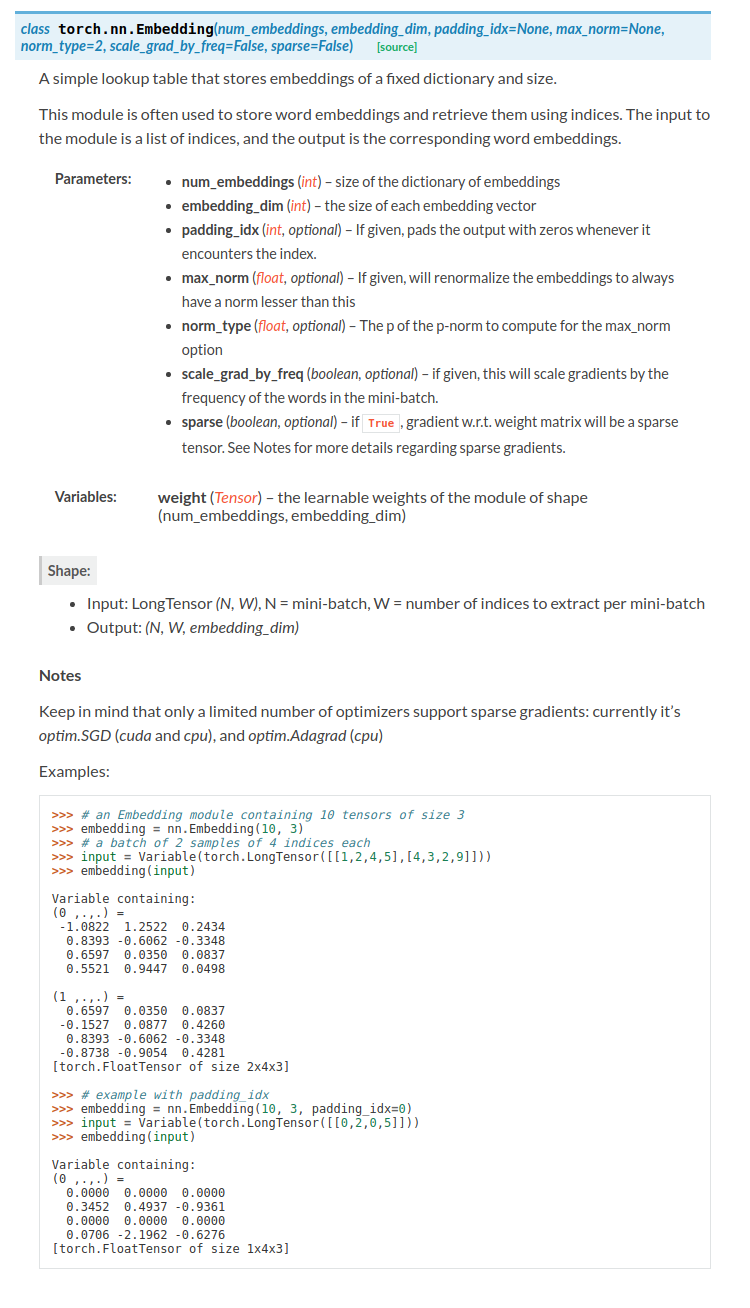

Pytorch documentation of LSTM class

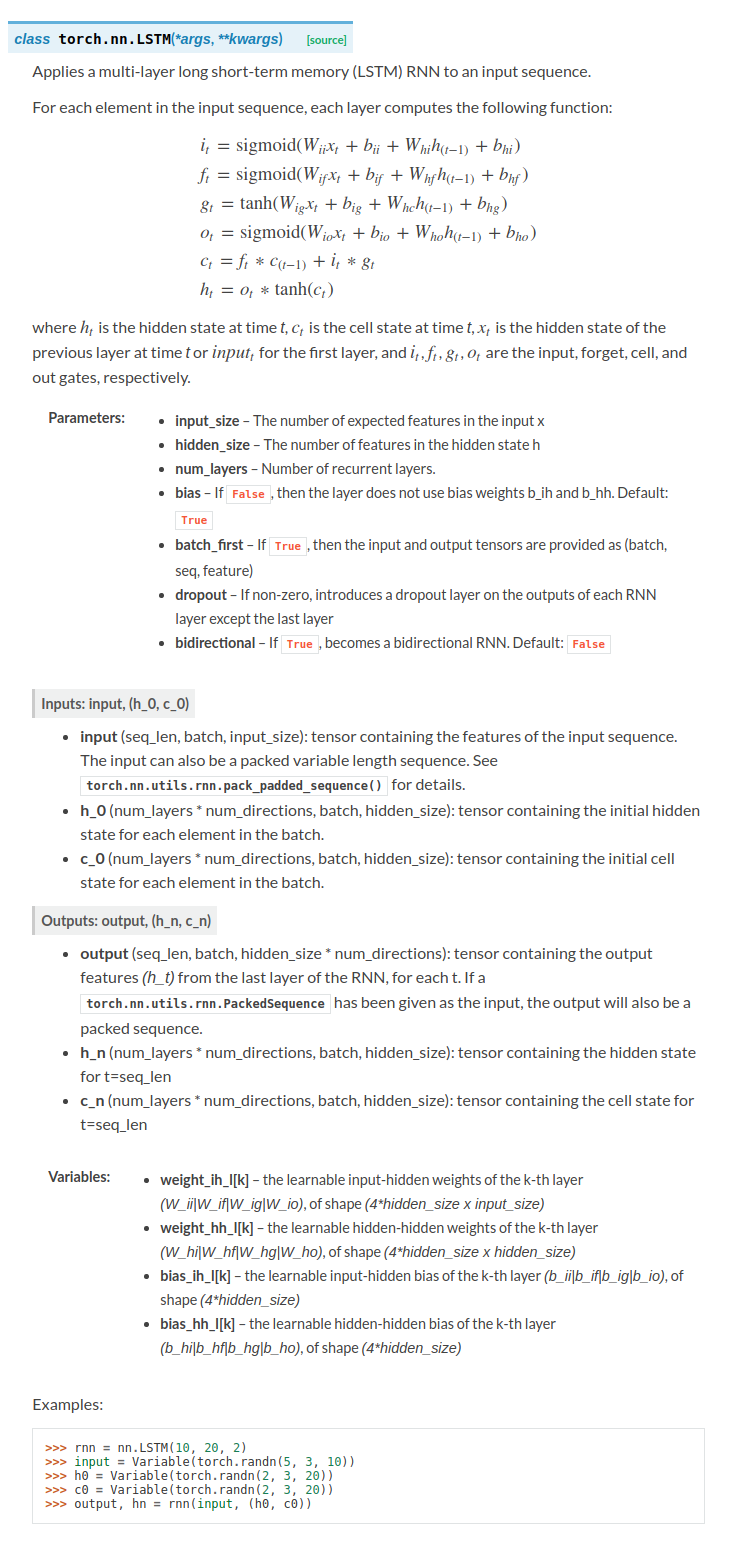

In [43]:
# Number of hidden units in each hidden layer
hidden_size = 512
# Number of recurrent layers
num_layers = 2
# Dropout
dropout = 0

class WordLSTM(nn.Module):
    
    def __init__(self, embeddings, vocab_size, num_dim, hidden_size, num_layers, dropout):
        super(WordLSTM, self).__init__()
        # Hyperparameters
        self._vocab_size = vocab_size
        self._num_dim = num_dim
        self._hidden_size = hidden_size
        self._num_layers = num_layers
        self._dropout = dropout
        
        # Hidden layer and cell state of model
        # Initialize before training, validation and testing
        self.hidden = None
        
        # Lookup table that stores word embeddings
        self.embed = nn.Embedding(self._vocab_size, self._num_dim)
        self.embed.weight.data.copy_(torch.from_numpy(embeddings))
        self.embed.weight.requires_grad = False
        # Pytorch lstm module
        self.lstm = nn.LSTM(self._num_dim, self._hidden_size, self._num_layers, dropout=self._dropout)
        # Linear transformation 
        self.hidden_to_word = nn.Linear(self._hidden_size, self._vocab_size)
        
    def init_hidden(self, batch_size):
        return (Variable(torch.cuda.FloatTensor(self._num_layers, batch_size, self._hidden_size).fill_(0), 
                         requires_grad=False), 
                Variable(torch.cuda.FloatTensor(self._num_layers, batch_size, self._hidden_size).fill_(0), 
                         requires_grad=False))
        
    def forward(self, batches, seq_len, batch_size):
        inputs = Variable(torch.cuda.FloatTensor(seq_len, batch_size, self._num_dim), requires_grad=False)
        # Embedding lookup
        for t in range(seq_len):
            inputs[t] = self.embed(batches[t])
        output, self.hidden = self.lstm(inputs, (self.hidden))
        logits = self.hidden_to_word(output)
        return logits
    
word_lstm = WordLSTM(embeddings, vocab_size, num_dim, hidden_size, num_layers, dropout)
word_lstm.cuda()

WordLSTM(
  (embed): Embedding(71291, 300)
  (lstm): LSTM(300, 512, num_layers=2)
  (hidden_to_word): Linear(in_features=512, out_features=71291)
)

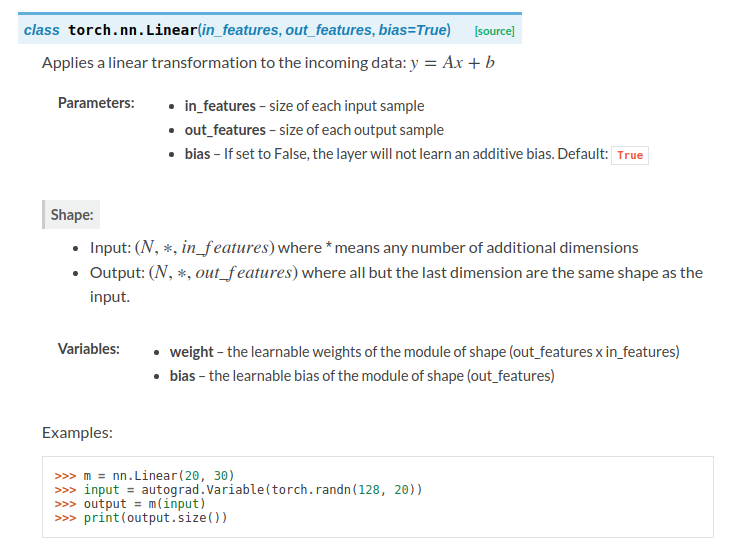

In [44]:
learning_rate = 0.1
# Filter parameters that do not require gradients
parameters = filter(lambda p: p.requires_grad, word_lstm.parameters())
optimizer = torch.optim.SGD(parameters, lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

def train():
    # Clear model gradients
    word_lstm.zero_grad()
    # Clear optimizer gradients
    optimizer.zero_grad()
    # Clear hidden state of LSTM
    word_lstm.hidden = word_lstm.init_hidden(batch_size)
    loss = 0
    # Get (seq_len + 1) batches
    batches = train_batches._next()
    logits = word_lstm(batches, seq_len, batch_size)
    for t in range(seq_len):
        loss += loss_function(logits[t].cuda(), Variable(batches[t+1].cuda()))
    loss.backward()
    nn.utils.clip_grad_norm(word_lstm.parameters(), 5)
    optimizer.step()
    return loss / seq_len

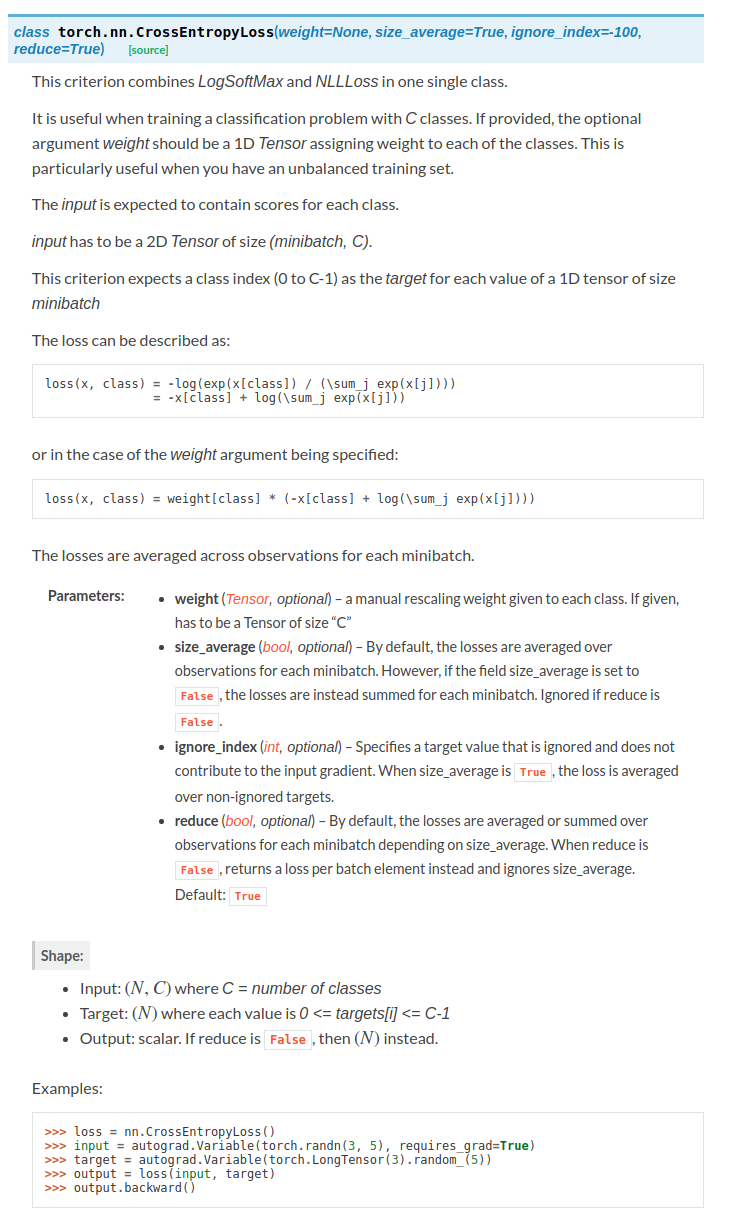

In [45]:
num_iters = 50001 

cudnn.benchmark = True
cudnn.fasttest = True

# Correct loss would be ~= -ln(1/num_classes)
for step in range(num_iters):
    step_loss = train()
    if i%1000 == 0: 
        print('Minibatch loss at step %d: %.3f ' % (step, step_loss))

Average loss at step 0: 11.173 
Average loss at step 1000: 7.377 


KeyboardInterrupt: 